1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

In [240]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm

Cobyla: [ 0.08981175 -0.7125711 ]
Nelder-Mead: [-0.08980706  0.71266256]


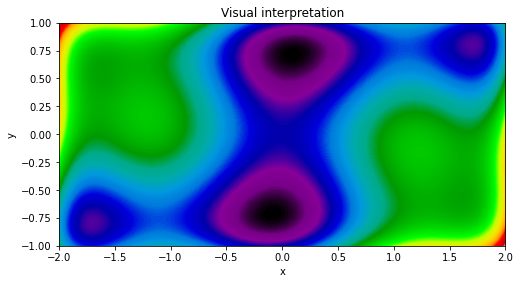

In [241]:
def f(x):
    return (4.0 - 2.1*x[0]**2 + (x[0]**4)/3.0)*x[0]**2 + x[0]*x[1] + (4.0*x[1]**2 - 4.0)*x[1]**2
 
x = np.linspace(-2, 2, 500)
y = np.linspace(-1, 1, 500)

X, Y = np.meshgrid(x, y)
Z = f([X,Y])
fig, ax = plt.subplots(figsize=(8, 5))
image = ax.imshow(Z, extent=[-2, 2, -1, 1], cmap='nipy_spectral')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Visual interpretation')

initial_guess = np.array([[-0.2,-0.70],[-0.2,0.75],[0,0]])
bound = [(-2,2),(-1,1)]

# Using Cobyla
r1 = scipy.optimize.minimize(f, x0=np.random.uniform(-1,1,size=2), bounds=bound, method="cobyla")
print("Cobyla:", r1.x)

# Using Nelder-Mead method
r2 = scipy.optimize.minimize(f, x0=np.random.uniform(-1,1,size=2), bounds=bound, method="nelder-mead")
print("Nelder-Mead:",r2.x)

Comments :
Different methods yield different results for the minima. Considering that the function is even, it has two obvious minima.
One is picked up using Cobyla algorithm and the other using Nelder-Mead method.
At (0,0) the function reaches a minima.

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

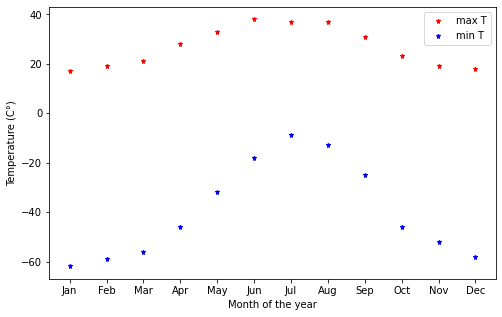

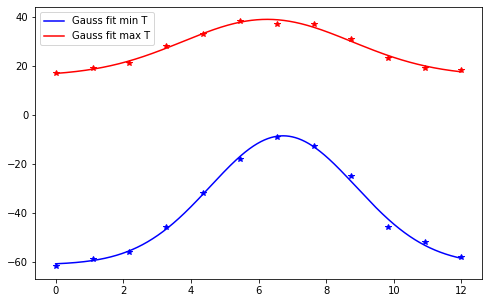

Goodness of fit for min T: 0.8913798222855085
Goodness of fit for max T: 0.9986661550329581


In [252]:
#Plotting temperatures
max_t = np.array([17, 19, 21, 28, 33, 38, 37, 37, 31, 23, 19, 18])
min_t = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])
months = np.array(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])

plt.figure(figsize=(8,5))
plt.plot(months, max_t,'*', markersize=5, label='max T', color = 'red')
plt.plot(months, min_t,'*', markersize=5, label='min T', color = 'blue')
plt.xlabel('Month of the year')
plt.ylabel('Temperature (C°)')
plt.legend(loc = "best")
plt.show()

#Suitable function; we'll try gaussian

def gauss(x, c, mu, sigma, offset):
    return c*np.exp( -np.power(x - mu, 2.) / (2 * np.power(sigma, 2.) ) ) + offset

#Fit this function to the data and plot the result

x_data = np.linspace(0, 12, num=12)
x = np.arange(0,12,0.01)


#min_t
y_data = min_t
min_params, min_params_covariance = optimize.curve_fit(gauss, x_data, y_data, p0=[60,6.5, 1,-60])


plt.figure(figsize=(8,5))
plt.plot(x_data, y_data, '*', color = 'blue')
plt.plot(x, gauss(x, *min_params), color = 'blue', label='Gauss fit min T')

residuals1 = min_t - gauss(np.arange(0, 12), *min_params)
ss_res1 = np.sum(residuals1**2)
ss_tot1 = np.sum((min_t - np.mean(min_t))**2)
r_squared1 = 1 - (ss_res1 / ss_tot1)


#max_t
y_data = max_t
max_params, max_params_covariance = optimize.curve_fit(gauss, x_data, y_data, p0=[30,6.5, 1,20])


plt.plot(x_data, y_data, '*', color = 'red')
plt.plot(x, gauss(x, *max_params), color = 'red', label='Gauss fit max T')

residuals2 = max_t - gauss(np.arange(0, 12), *max_params)
ss_res2 = np.sum(residuals2**2)
ss_tot2 = np.sum((min_t - np.mean(max_t))**2)
r_squared2 = 1 - (ss_res2 / ss_tot2)

plt.legend(loc='best')
plt.show()
print("Goodness of fit for min T:", r_squared1)
print("Goodness of fit for max T:", r_squared2)

Comments : Since R^2 is close to 1, the gaussian fits well the data.

3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

Chi^2: 2263.1191115389147
P-value: 0.0
As p-value is 0, it is not considered a satisfactory fit.


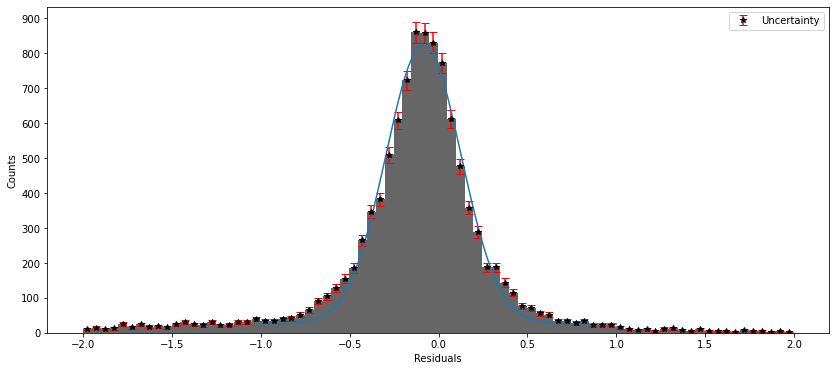

In [332]:
import pandas as pd
from matplotlib.ticker import MaxNLocator

initial_data = np.load("residuals_261.pkl", allow_pickle = True)
initial_data = initial_data.tolist()
Data = pd.DataFrame(initial_data)
df = Data['residuals']
df = df[abs(df) < 2]

n_bins = 80
counts,binEdges = np.histogram(df,bins=n_bins)
Mid_bins = 1/2 * (binEdges[1:] + binEdges[:-1])

def gauss(x, mean, sigma, offset, amplitude):
    return amplitude * stats.norm.pdf(x, mean, sigma) + offset

bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
meanStd = np.sqrt(counts)
popt_gauss, pcov_gauss = optimize.curve_fit(gauss, bincenters, counts, full_output=False,p0 = [0.1,0.5,0,1200])
x = np.linspace(int(min(df)),int(max(df)),1000)

fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.hist(df, n_bins, histtype='bar', color='black', alpha = 0.6)

ax1.yaxis.set_major_locator(MaxNLocator(integer = True))
ax1.errorbar(Mid_bins,counts,yerr = (np.sqrt(counts)), color = "black", ecolor = 'r',fmt = '*', capsize = 4, label = "Uncertainty")
ax1.legend()
ax1.set_xlabel("Residuals")
ax1.set_ylabel("Counts")
ax1.plot(x, gauss(x, *popt_gauss), label = 'fitted curve')

chi2 = np.sum(((counts - gauss(Mid_bins,popt_gauss[0],popt_gauss[1],popt_gauss[2],popt_gauss[3]))/meanStd)**2)
print('Chi^2:', chi2)
dof = n_bins - 1
p_value = 1. - stats.chi2.cdf(chi2, dof)
print("P-value:", p_value)
print("As p-value is 0, it is not considered a satisfactory fit.")


4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is necessary.

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
a = pd.read_csv("munich_temperatures_average_with_bad_data.txt",names=['Year','Temperature'],delimiter=" ")
df=a.loc[a['Year'].between(2008,2012)].copy()

Fit parametres:
 [-9.98813369 12.33302301  9.38411487]
Annual average temperature: 9.384097733283356 C˚
Maximal annual temperature: 19.372195568442635 C˚
Minimal annual temperature: -0.6037388871173217 C˚


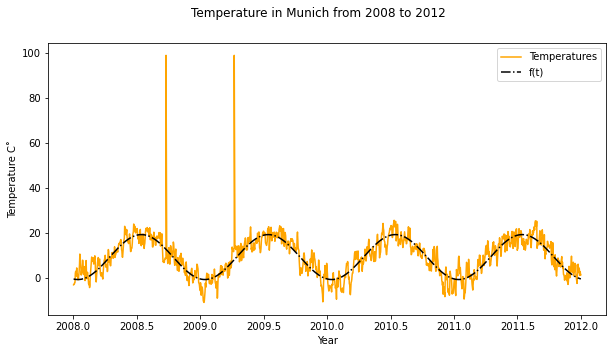

In [103]:
def f(t,a,b,c):
    return a*np.cos(2*np.pi*t+b)+c 

popt_f, pcov_f = curve_fit(f, df["Year"],df['Temperature'])
t_range=np.linspace(df['Year'].min(),df['Year'].max(),1000) 


fig=plt.figure(figsize=(10,5))
fig.suptitle('Temperature in Munich from 2008 to 2012')

plt.plot(df['Year'],df['Temperature'],label='Temperatures',c='orange')
plt.plot(t_range, f(t_range,*popt_mun), c='black', linestyle='dashdot' ,label='f(t)',)

plt.xlabel('Year')
plt.ylabel('Temperature C˚')
plt.legend(loc='best')

mean=np.mean(f(df['Year'],*popt_f))
max_temp=np.max(f(df['Year'],*popt_f))
min_temp=np.min(f(df['Year'],*popt_f))

print('Fit parametres:\n', popt_f)
print('Annual average temperature:',mean,'C˚')
print('Maximal annual temperature:',max_temp,'C˚')
print('Minimal annual temperature:',min_temp,'C˚')
# Parameter b is simply the offset from the origin, i.e it slides the plotted function to the left or right

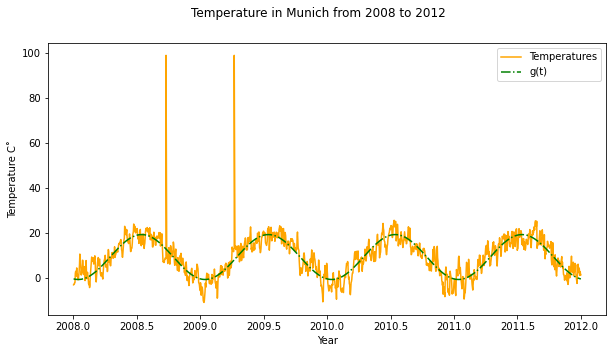

In [104]:
def g(t,a,b,c,d):
    return a*np.cos(2*np.pi*t*b+c)+d

popt_g, pcov_g = curve_fit(g, df['Year'],df['Temperature'])

fig=plt.figure(figsize=(10,5))
fig.suptitle('Temperature in Munich from 2008 to 2012')

plt.plot(df['Year'],df['Temperature'],label='Temperatures',c='orange')
plt.plot(t_range, g(t_range,*popt_g), c='g', linestyle='dashdot' ,label='g(t)')

plt.xlabel('Year')
plt.ylabel('Temperature C˚')
plt.legend(loc='best')

In [116]:
from scipy import stats
ssr_f = np.sum((df['Temperature'] - f(df['Year'],*popt_mun))**2)
ssr_g = np.sum((df['Temperature'] - g(df['Year'],*popt_mun1))**2)

tss = np.sum((np.mean(df['Temperature']) - df['Temperature'])**2)

rsq_f = 1 - ssr_f / tss
rsq_g = 1 - ssr_g / tss

print('SSR for f(t):',ssr_f)
print('SSR for g(t):',ssr_g,'\n')

print('R for f(t):',np.sqrt(rsq_f))
print('R for g(t):',np.sqrt(rsq_g),'\n')

def Ftest(ssr_1, ssr_2, ndof_1, ndof_2, nbins, verbose=False):
    F = ((ssr_1 - ssr_2)/(ndof_2 - ndof_1)) / (ssr_2/(nbins - ndof_2))
    CL = 1. - stats.f.cdf(F, ndof_2 - ndof_1, nbins - ndof_2)
    if verbose: print(CL, ",additional parameter necessary:" if CL < 0.10 else "=> additional parameter not necessary")
    return CL

ndof_f=2
ndof_g=3
N=len(df['Temperature'])

print('F-Test:')
cl_f_vs_g = Ftest(ssr_f, ssr_g, ndof_f, ndof_g, N, verbose=True)

SSR for f(t): 34359.85859996652
SSR for g(t): 34352.79405393762 

R for f(t): 0.8243745993663526
R for g(t): 0.8244145541804488 

F-Test:
0.5840708189873394 => additional parameter not necessary
